In [1]:
# THIS WILL COME FROM A COMMAND-LINE ARGUMENT !!!!
# to allow running multiple scripts maskrcnn's inference only allows 1 GPU
# see: https://stackoverflow.com/questions/28549641/run-multiple-python-scripts-concurrently

n_gpus = 3
subset = 0

In [2]:
#%% =================================================================
import os
import sys
import numpy as np
import hickle as hkl
# import tensorflow as tf
from pandas import DataFrame as df

# Root directory of the project
ROOT_DIR = "/home/mohamedt/Desktop/WSI_Segmentation/Codes/mask_RCNN/"
sys.path.append(ROOT_DIR)  # To find local version of the library
sys.path.append(ROOT_DIR + "../")
sys.path.append(ROOT_DIR + "../WSI_Annotation/")

# Import Mask RCNN
import mrcnn.model as modellib

import TCGA_nucleus as nucleus 
from maskrcnn_utils_local import (
    convert_mask_to_three_channels, discard_edge_nuclei,
    add_contour_channel, add_nucleus_info_to_df)
from WSI_Annotation.SQLite_Methods import SQLite_Methods
from WSI_Annotation.general_utils import parse_coords_to_csv, list_to_str

Using TensorFlow backend.


In [3]:
#%% =================================================================
# Params
#=================================================================

model_to_use = "nucleus20180720T1413"
model_epoch = "mask_rcnn_nucleus_0030.h5"
model_epoch_short = model_epoch.split("_")[-1].split(".h5")[0]

image_path = "/mnt/Tardis/MohamedTageldin/TCGA_dataset/input_for_mrcnn/images/"

model_weights_path = "/home/mohamedt/Desktop/WSI_Segmentation/Models/TCGA_maskrcnn/19July2018/%s/%s" % (
    model_to_use, model_epoch)

# where the masks will be saved
pred_save_path = "/home/mohamedt/Desktop/WSI_Segmentation/Results/TCGA_maskrcnn/19July2018/%s_%s/" % (
    model_to_use, model_epoch_short)

# Where the sqlite database will be saved. NOTE the following: 
# This CANNOT be something mounted like tardis, otherwise database
# gets loocked and you can't do anything. see he following: 
# https://ubuntuforums.org/showthread.php?t=780891 
db_path = "/home/mohamedt/Desktop/WSI_Segmentation/Results_local/TCGA_maskrcnn/19July2018/%s_%s/" % (
    model_to_use, model_epoch_short)

logs_dir = "/home/mohamedt/Desktop/WSI_Segmentation/Models/TCGA_maskrcnn/tmp/"

In [4]:
#%%============================================================================
# Ground work
#==============================================================================

assert subset < n_gpus

# only print if one thread running
verbose= True if n_gpus == 1 else False

# make sure save path exists
if not os.path.exists(pred_save_path): os.makedirs(pred_save_path)
if not os.path.exists(db_path): os.makedirs(db_path)

# ".db" must not exist beforehand
db_file_path = db_path + "%s_%s_subset%d.db" % (model_to_use, model_epoch_short, subset)
assert not os.path.exists(db_file_path), ".db file must be created anew to prevent conflict"

# get entire images list in dataset
ext = ".png"
image_ids = [j.split(ext)[0] for j in os.listdir(image_path) if ext in j]
image_ids.sort() # to make sure subsets are consistent

# Restrict to images to predict (a subset that is 1/N_GPUs of total number)
if n_gpus > 1:
    n_images_total = len(image_ids)
    subset_size = n_images_total // n_gpus
    subset_bounds = list(np.arange(0, n_images_total, subset_size))
    subset_bounds[-1] = n_images_total
    image_ids = image_ids[subset_bounds[subset]:subset_bounds[subset+1]]

In [5]:
#%%============================================================================
# Prep for maskRCNN inference
#==============================================================================

# Inference Configuration
config_inference = nucleus.NucleusConfig(
    is_training= False, verbose=verbose)
if verbose: config_inference.display()
    
# load dataset
dataset = nucleus.NucleusDataset(config= config_inference)
dataset.load_nucleus(specific_ids= image_ids)
dataset.prepare()

# Create model in inference mode
model = modellib.MaskRCNN(
    mode= "inference", model_dir= logs_dir, 
    config= config_inference)

# Load weights
if verbose: print("Loading weights ", model_weights_path)
model.load_weights(model_weights_path, by_name=True)

# Get bounds for which images go to what batch (just the bounds)
n_images_tot = len(dataset.image_ids)  
idx_bounds = list(np.arange(0, n_images_tot, config_inference.BATCH_SIZE))
if idx_bounds[-1] != n_images_tot:
    idx_bounds.append(n_images_tot)

Re-starting from epoch 30


In [6]:
#%%============================================================================
# Now go through batches and do inference
#==============================================================================

n_batches = len(idx_bounds) -1
for batch_idx in range(n_batches):
    
    if verbose: print("Batch %d of %d" % (batch_idx, n_batches))

    # Get relevant part of im_label_list_all  
    idx_start = idx_bounds[batch_idx]
    idx_end = idx_bounds[batch_idx + 1]    
    
    # load images
    imlist = []
    for image_id in dataset.image_ids[idx_start:idx_end]:
        imlist.append(dataset.load_image(image_id))
        
    # Detect objects in this batch of images
    r = model.detect(imlist, verbose=0)    
        
    # Init df to save coords for this batch
    Annots_DF = df(columns= [
        "unique_nucleus_id",
        "slide_name", 
        "nucleus_label", 
        "nucleus_label_confidence",
        "fov_offset_xmin_ymin", 
        "roi_offset_xmin_ymin", 
        "center_relative_to_slide_x_y",
        "bounding_box_relative_to_slide_xmin_ymin_xmax_ymax",
        "boundary_relative_to_slide_x_coords",
        "boundary_relative_to_slide_y_coords",
    ])
    
    #%% =================================================================
    # Save coords for all instances in each image in batch
    #=================================================================

    for imidx in range(len(r)):

        # Extract image info
        iminfo = dataset.image_info[idx_start:idx_end][imidx]

        # convert to three channels
        mask = convert_mask_to_three_channels(
            r[imidx]['masks'], class_ids= r[imidx]['class_ids'], 
            scores= r[imidx]['scores'])

        # discard edge nuclei
        mask = discard_edge_nuclei(mask, edge=64, keep_threshold=0.5)

        # Add contour channel
        mask = add_contour_channel(mask)

        # save mask as hickle binary
        mask = mask.astype(np.float32)    
        savename = pred_save_path + iminfo['id'] + ".hkl"
        with open(savename, 'w') as f:
            hkl.dump(mask, f) 

        # Add nucleus instance info to annotation database for this batch
        Annots_DF = add_nucleus_info_to_df(Annots_DF=Annots_DF, iminfo=iminfo, mask=mask)
        
    #%% =================================================================
    # Flush batch df into sqlite database
    #=================================================================

    # Prep SQLite database to save results
    sql = SQLite_Methods(db_path = db_path + "%s_%s_subset%d.db" % (
        model_to_use, model_epoch_short, subset))

    # get SQL formatted strings
    Annots_sql = sql.parse_dframe_to_sql(Annots_DF, primary_key='unique_nucleus_id')

    # create tables if non-existent
    if batch_idx == 0:
        sql.create_sql_table(tablename='Annotations', create_str= Annots_sql['create_str'])    
        
    # Add individual annotations
    for annotidx, annot in Annots_DF.iterrows(): 
        with sql.conn:
            sql.update_sql_table(tablename='Annotations', entry= annot, 
                             update_str= Annots_sql['update_str'])
    
    # commit and close
    sql.commit_changes()
    sql.close_connection()
        
    # TEMPORARY !!!!! REMOVE MEEEEEEEE !!!!!! -----
    break
    # TEMPORARY !!!!! REMOVE MEEEEEEEE !!!!!! -----

/home/mohamedt/.conda/envs/maskrcnn/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [7]:
#========================================================================
#========================================================================
#========================================================================

In [ ]:
a

In [ ]:
import matplotlib.pylab as plt
%matplotlib inline

In [15]:
Annots_sql['create_str']

'unique_nucleus_id text NOT NULL PRIMARY KEY, slide_name text, nucleus_label text, nucleus_label_confidence integer, fov_offset_xmin_ymin text, roi_offset_xmin_ymin text, center_relative_to_slide_x_y text, bounding_box_relative_to_slide_xmin_ymin_xmax_ymax text, boundary_relative_to_slide_x_coords text, boundary_relative_to_slide_y_coords text'

In [16]:
Annots_sql['update_str']

':unique_nucleus_id, :slide_name, :nucleus_label, :nucleus_label_confidence, :fov_offset_xmin_ymin, :roi_offset_xmin_ymin, :center_relative_to_slide_x_y, :bounding_box_relative_to_slide_xmin_ymin_xmax_ymax, :boundary_relative_to_slide_x_coords, :boundary_relative_to_slide_y_coords'

In [17]:
sql = SQLite_Methods(db_path = db_path + "%s_%s_subset%d.db" % (
    model_to_use, model_epoch_short, subset))

In [18]:
sql.c.execute("PRAGMA TABLE_INFO('Annotations')")
[j[1] for j in sql.c.fetchall()]

['unique_nucleus_id',
 'slide_name',
 'nucleus_label',
 'nucleus_label_confidence',
 'fov_offset_xmin_ymin',
 'roi_offset_xmin_ymin',
 'center_relative_to_slide_x_y',
 'bounding_box_relative_to_slide_xmin_ymin_xmax_ymax',
 'boundary_relative_to_slide_x_coords',
 'boundary_relative_to_slide_y_coords']

In [19]:
sql.c.execute("SELECT * FROM Annotations")
annots = sql.c.fetchone()
annots

('TCGA-A1-A0SP-DX1_8003_53861',
 'TCGA-A1-A0SP-DX1',
 'lymphocyte',
 87,
 '1024,0',
 '6798,53719',
 '8003,53861',
 '7986,53842,8020,53881',
 '7995,7996,7997,7998,7994,7998,7999,8000,8001,7993,8001,8002,7993,8002,8003,7992,8003,8004,7992,8004,8005,7992,8005,8006,7992,8006,8007,7992,8007,8008,7992,7993,8008,8009,8010,7993,8010,8011,8012,7993,7994,8012,8013,7994,8013,8014,8015,7994,7995,8015,8016,8017,7995,8017,8018,7995,8018,8019,7995,8019,7995,8019,8020,7995,8020,7994,7995,8020,7993,8020,7990,7991,7992,8020,7988,7989,8020,7987,8020,7986,8020,7986,8020,7986,8019,7986,8019,7986,8009,8010,8011,8012,8019,7986,8007,8008,8012,8013,8014,8018,7986,8006,8014,8015,8016,8017,7986,8005,7986,8004,7986,8004,7986,8003,7986,8002,7986,7987,8001,7987,7988,7989,8000,7989,7990,7991,7997,7998,7999,7991,7992,7993,7994,7995,7996',
 '53842,53842,53842,53842,53843,53843,53843,53843,53843,53844,53844,53844,53845,53845,53845,53846,53846,53846,53847,53847,53847,53848,53848,53848,53849,53849,53849,53850,53850,53850

In [23]:
instanceno = 75

roi_offset_xmin, roi_offset_ymin = Annots_DF.loc[instanceno, "roi_offset_xmin_ymin"].split(',')
fov_offset_xmin, fov_offset_ymin = Annots_DF.loc[instanceno, "fov_offset_xmin_ymin"].split(',')

x_offset = int(roi_offset_xmin) + int(fov_offset_xmin)
y_offset = int(roi_offset_ymin) + int(fov_offset_ymin)

# seed
seed_X, seed_Y = Annots_DF.loc[instanceno, "center_relative_to_slide_x_y"].split(',')
seed_X = int(seed_X) - x_offset
seed_Y = int(seed_Y) - y_offset

# bounding box
xmin, ymin, xmax, ymax = Annots_DF.loc[instanceno, "bounding_box_relative_to_slide_xmin_ymin_xmax_ymax"].split(',')
xmin = int(xmin) - x_offset
xmax = int(xmax) - x_offset
ymin = int(ymin) - y_offset
ymax = int(ymax) - y_offset

# boundary
boundary_X = [int(j) - x_offset for j in Annots_DF.loc[instanceno, "boundary_relative_to_slide_x_coords"].split(',')]
boundary_Y = [int(j) - y_offset for j in Annots_DF.loc[instanceno, "boundary_relative_to_slide_y_coords"].split(',')]

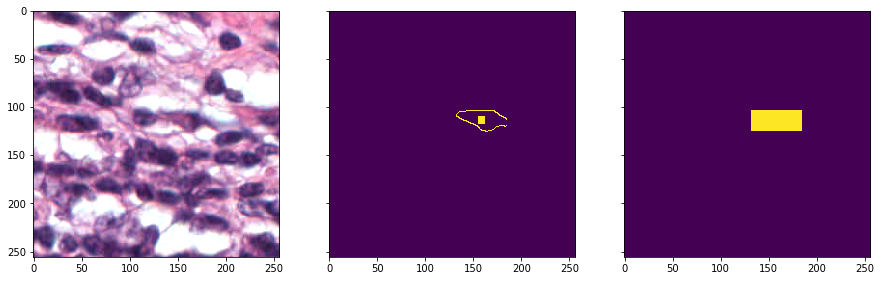

In [24]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,15))

ax1.imshow(plt.imread(iminfo['path']))

mask_instance = np.zeros(mask.shape[:2])
mask_instance[seed_Y-4:seed_Y+4, seed_X-4:seed_X+4] = 1
mask_instance[boundary_Y, boundary_X] = 1
ax2.imshow(mask_instance)

mask_instance = np.zeros(mask.shape[:2])
mask_instance[ymin:ymax, xmin:xmax] = 1
ax3.imshow(mask_instance)

plt.show()

In [ ]:
#%% =================================================================
# Read saved mask and visualize
#=================================================================

from bootstrapping_utils import occupy_full_GT_range
from matplotlib.colors import ListedColormap

# A named color map encoding class
clist = [
    'black', # 0- exclude
    'red', # 1- tumor
    'green', # 2- stroma / fibroblast
    'blue', # 3- lymphocyte
    'cyan', # 4- plasma cell
    'slateblue', # 5- other_immune
    'grey',  # 6- other
    ]
cmap_classlabels = ListedColormap(clist)
n_classes = len(clist)

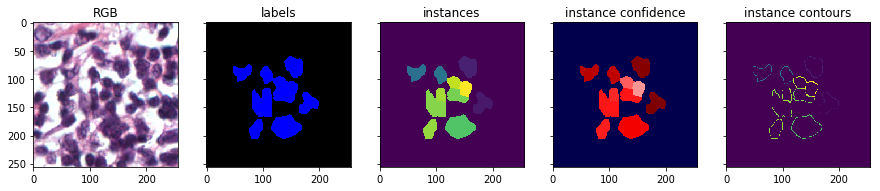

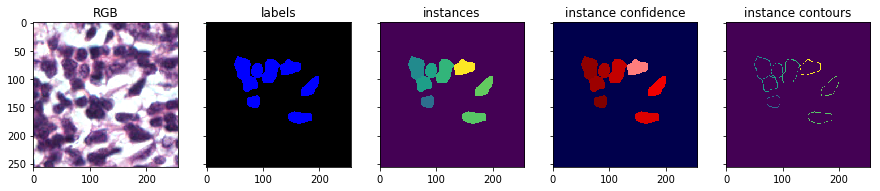

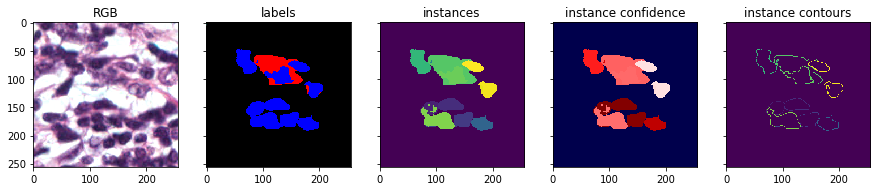

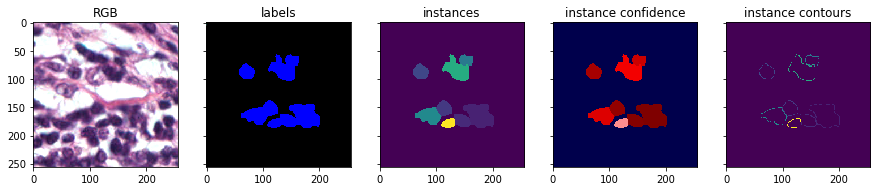

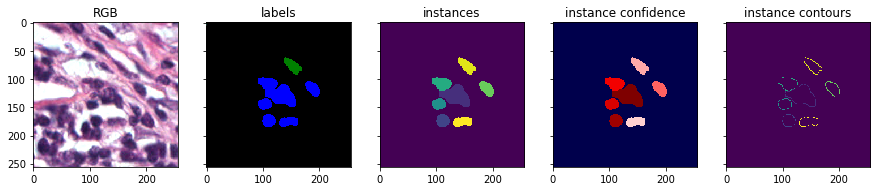

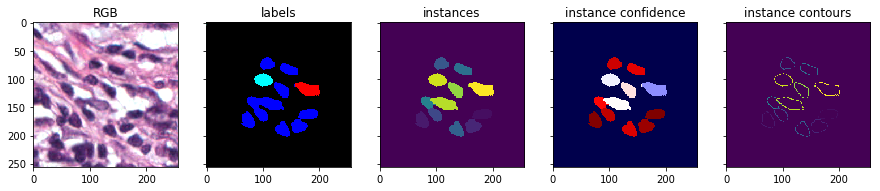

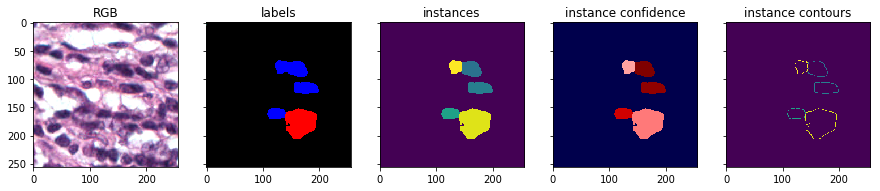

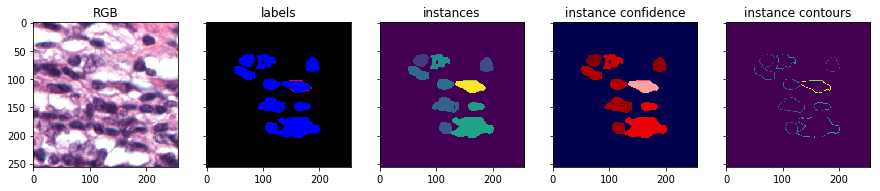

In [14]:
for imidx in range(len(r)):

    iminfo = dataset.image_info[idx_start:idx_end][imidx]
    
    # Read mask file (hkl)
    im = plt.imread(iminfo['path'])
    mask = hkl.load(pred_save_path + iminfo['id'] + ".hkl") 
    
    # prepare labels for visualization
    mask[..., 0] = occupy_full_GT_range(mask[..., 0], n_classes)
    
    # visualize
    f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharey=True, figsize=(15,15))
    ax1.imshow(im); ax1.set_title("RGB")
    ax2.imshow(mask[..., 0], cmap= cmap_classlabels); ax2.set_title("labels")
    ax3.imshow(mask[..., 1]); ax3.set_title("instances")
    ax4.imshow(mask[..., 2], cmap= "seismic"); ax4.set_title("instance confidence")
    ax5.imshow(mask[..., 3]); ax5.set_title("instance contours")
    plt.show()

In [ ]:
#========================================================================
#========================================================================
#========================================================================